In [1]:
# Cell 1: Imports and data loading
from src.data_loader import DataLoader

loader = DataLoader()
df = loader.load()
returns = loader.compute_returns()

print(f"Data shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Data shape: (3914, 12)
Date range: 2010-01-04 00:00:00 to 2024-10-25 00:00:00

Columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'InterestRate', 'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil']


,Open,High,Low,Close,Volume,InterestRate,ExchangeRate,VIX,TEDSpread,EFFR,Gold,Oil
Date,,,,,,,,,,,,
2010-01-04,6.640000,6.810000,6.633333,6.746667,6514500.0,0.11,1.4419,20.04,0.17,0.12,1117.699951,81.510002
2010-01-05,6.643333,6.773333,6.643333,6.766667,4445100.0,0.11,1.4402,19.35,0.18,0.12,1118.099976,81.769997
2010-01-06,6.733333,6.786667,6.720000,6.763333,7340100.0,0.11,1.4404,19.16,0.19,0.12,1135.900024,83.180000
2010-01-07,6.750000,6.766667,6.630000,6.673333,8498400.0,0.11,1.4314,19.06,0.20,0.10,1133.099976,82.660004
2010-01-08,6.676667,6.766667,6.626667,6.743333,4347600.0,0.11,1.4357,18.13,0.20,0.11,1138.199951,82.750000


In [2]:
# Cell 2: Basic stats
print("=== Return Statistics ===")
print(returns.describe())
print(f"\nSkewness: {returns.skew():.3f}")  # Negative = left tail (crashes)
print(f"Kurtosis: {returns.kurtosis():.3f}")  # >3 = fat tails


=== Return Statistics ===
count    3913.000000
mean        0.000614
std         0.015529
min        -0.137063
25%        -0.006279
50%         0.000343
75%         0.008252
max         0.130180
Name: Close, dtype: float64

Skewness: -0.271
Kurtosis: 9.840


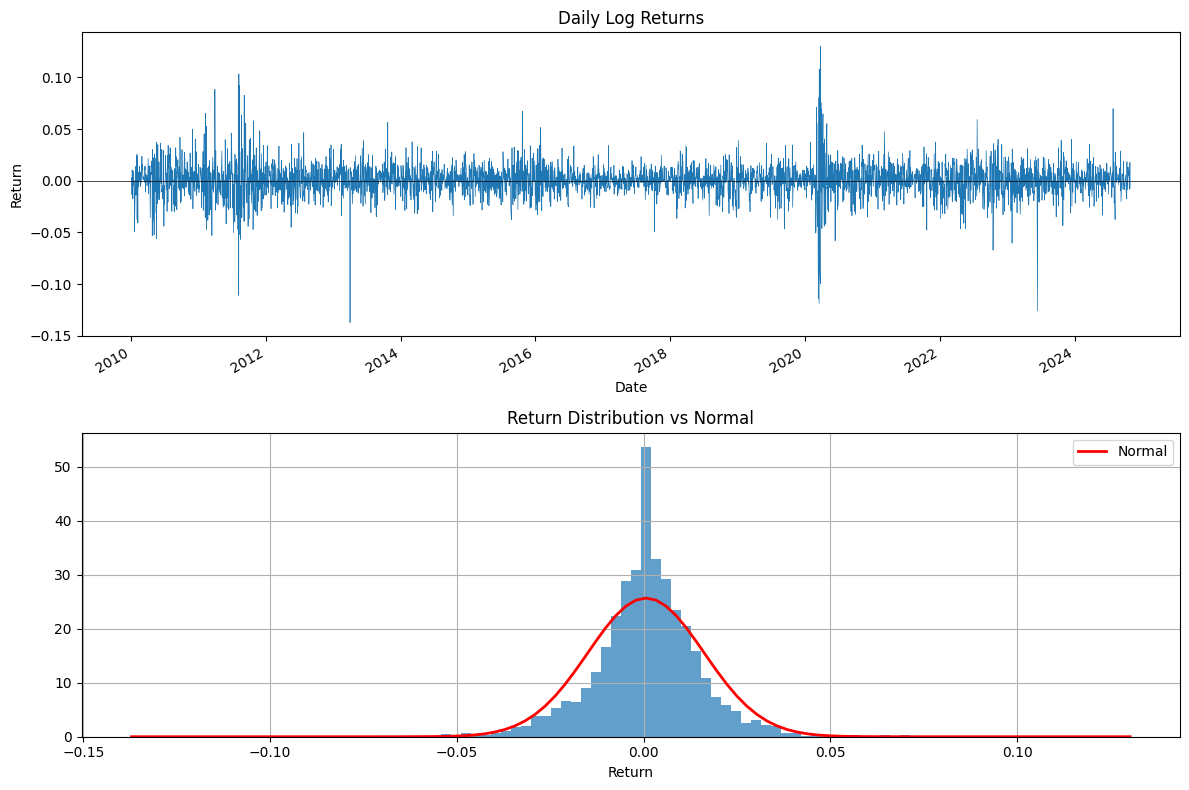

In [3]:
# Cell 3: Visualize returns
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Time series of returns
returns.plot(ax=axes[0], linewidth=0.5)
axes[0].set_title("Daily Log Returns")
axes[0].set_ylabel("Return")
axes[0].axhline(0, color="black", linewidth=0.5)

# Histogram vs normal distribution
returns.dropna().hist(bins=100, ax=axes[1], density=True, alpha=0.7)
axes[1].set_title("Return Distribution vs Normal")
axes[1].set_xlabel("Return")

# Overlay normal distribution
x = np.linspace(returns.min(), returns.max(), 100)
from scipy.stats import norm

axes[1].plot(
    x, norm.pdf(x, returns.mean(), returns.std()), "r-", linewidth=2, label="Normal"
)
axes[1].legend()

plt.tight_layout()
plt.show()

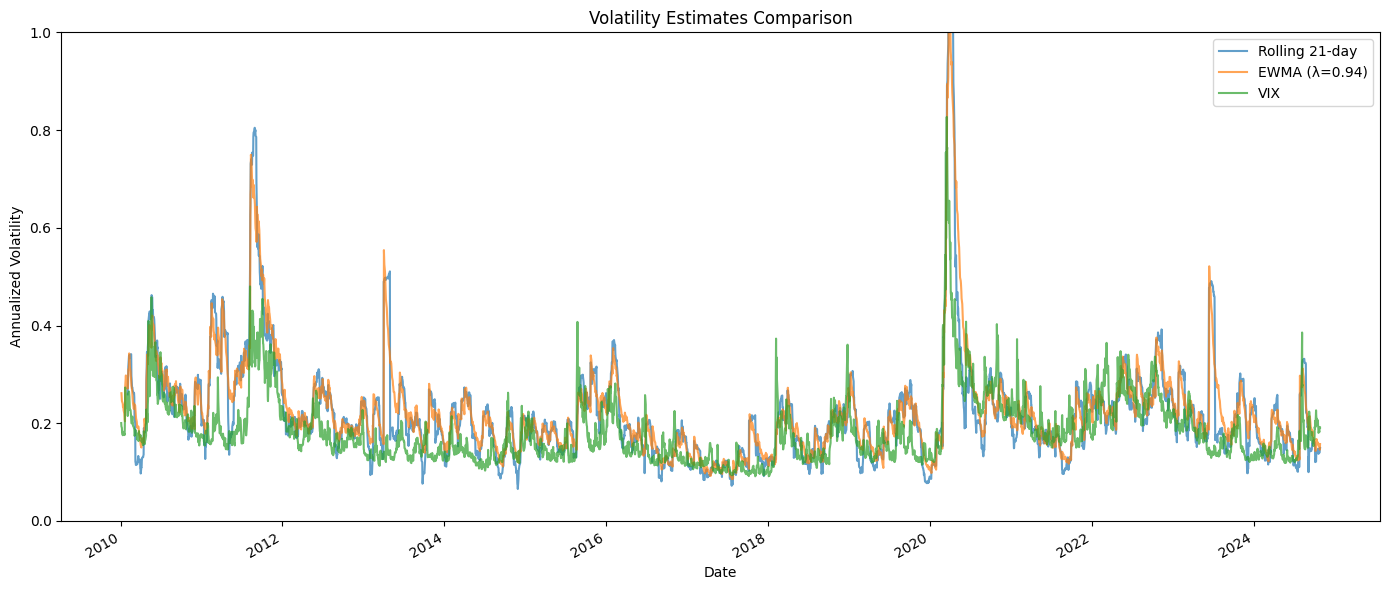

=== Volatility Correlation ===
            Rolling_21   EWMA    VIX
Rolling_21       1.000  0.949  0.678
EWMA             0.949  1.000  0.716
VIX              0.678  0.716  1.000


In [5]:
# Cell 4: Volatility clustering
from src.features import FeatureEngineer
from src.models.ewma import EWMAVolatility
import pandas as pd

fe = FeatureEngineer(returns)

# Compute different vol estimates
rolling_vol_21 = fe.rolling_volatility(21)

ewma = EWMAVolatility(lambda_param=0.94)
ewma.fit(returns.dropna())
ewma_vol = ewma.get_volatility()

# VIX from data (already annualized, but in percentage points)
vix = df["VIX"] / 100  # Convert to decimal

# Plot all three
fig, ax = plt.subplots(figsize=(14, 6))

rolling_vol_21.plot(ax=ax, label="Rolling 21-day", alpha=0.7)
ewma_vol.plot(ax=ax, label="EWMA (λ=0.94)", alpha=0.7)
vix.plot(ax=ax, label="VIX", alpha=0.7)

ax.set_title("Volatility Estimates Comparison")
ax.set_ylabel("Annualized Volatility")
ax.legend()
ax.set_ylim(0, 1.0)  # Cap at 100% for readability

plt.tight_layout()
plt.show()

# Correlation between estimates
print("=== Volatility Correlation ===")
vol_df = pd.DataFrame(
    {"Rolling_21": rolling_vol_21, "EWMA": ewma_vol, "VIX": vix}
).dropna()
print(vol_df.corr().round(3))

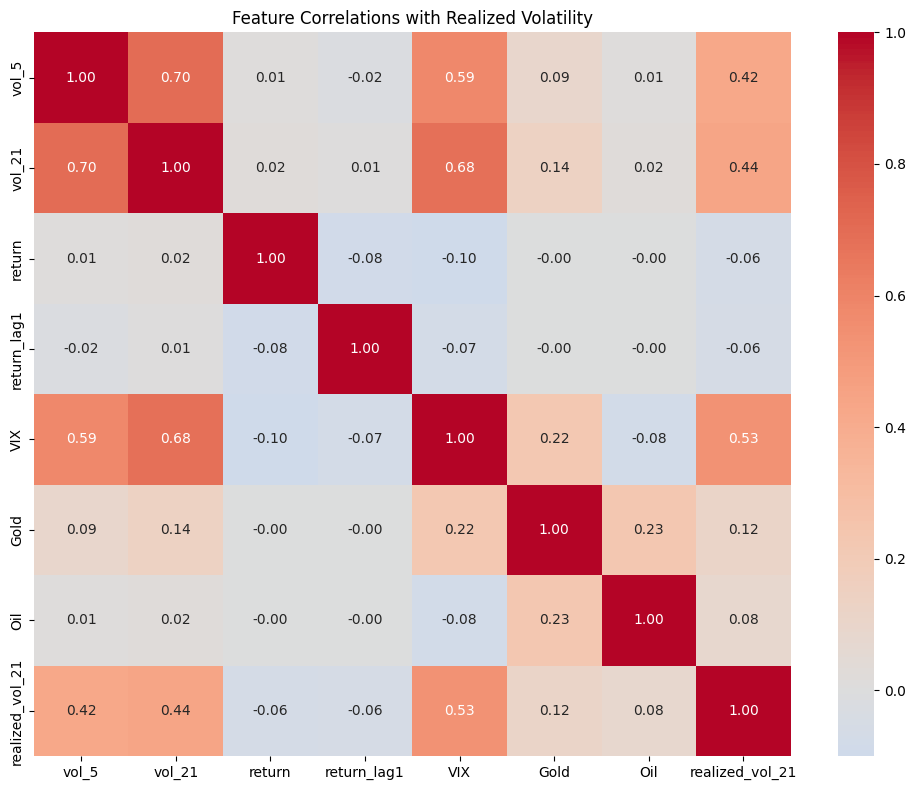

=== Correlation with Realized Vol ===
realized_vol_21    1.000000
VIX                0.533680
vol_21             0.440266
vol_5              0.424658
Gold               0.115343
Oil                0.083927
return_lag1       -0.058206
return            -0.063179
Name: realized_vol_21, dtype: float64


In [6]:
# Cell 5: Correlation analysis - Features vs Realized Vol
import seaborn as sns
import pandas as pd

# Get features and target
features = loader.get_features()
realized_vol = fe.realized_volatility(21)  # Forward-looking (target)

# Combine for correlation
analysis_df = pd.concat(
    [
        fe.rolling_volatility(5).rename("vol_5"),
        fe.rolling_volatility(21).rename("vol_21"),
        returns.rename("return"),
        returns.shift(1).rename("return_lag1"),
        features["VIX"].rename("VIX"),
        features["Gold"].rename("Gold"),
        features["Oil"].rename("Oil"),
        realized_vol.rename("realized_vol_21"),
    ],
    axis=1,
).dropna()

# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
corr = analysis_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax)
ax.set_title("Feature Correlations with Realized Volatility")
plt.tight_layout()
plt.show()

# Most correlated with target
print("=== Correlation with Realized Vol ===")
print(corr["realized_vol_21"].sort_values(ascending=False))